In [1]:
import warnings
warnings.filterwarnings("ignore")

## Research large moves in the futures markets

In [2]:

import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from dashapp import dashapp2 as dashapp
import dash_html_components as html
import dash_core_components as dcc
from itertools import accumulate 


importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

### important global variables

In [3]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


#### get all contracts in the options database

In [5]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200515
opttab max date:         max
0  20200515


In [6]:
def _create_batch_indices(l,n):
    ii = list(range(l))
    num = n
    # list of length in which we have to split 
    length_to_split = list(np.repeat(num,len(ii)/num )) + [len(ii)%num]
    print(length_to_split)

    # Using islice 
    r = [ii[x - y: x] for x, y in zip( 
              accumulate(length_to_split), length_to_split)] 
    return r
_create_batch_indices(11,3)

[3, 3, 3, 2]


[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]

In [7]:
def get_spread(contract_front,contract_back):
    sql = f"""
    with 
    f1 as (
        select *
        from {futtab} 
        where symbol in ('{contract_front}','{contract_back}')
    )
    select * from f1 
    """
    df = pga.get_sql(sql)
    df1 = df[df.symbol==contract_front].copy()
    df2 = df[df.symbol==contract_back].copy()
    df1['front'] = df1.close
    df2['back'] = df2.close
    df_both = df1[['settle_date','front']].merge(
        df2[['settle_date','back']],on='settle_date',how='inner')
    df_both['spread'] = df_both.front - df_both.back
    return df_both

In [8]:
def _commod_list():
    sql = f"""select distinct substring(symbol,1,2) commod from {futtab}
    order by substring(symbol,1,2) """
    df = pga.get_sql(sql)
    return df

In [9]:
df_commod = _commod_list()

In [10]:
df_commod

,commod
0,A6
1,AD
2,AE
3,AP
4,B6
...,...
199,ZQ
200,ZR
201,ZS
202,ZT


In [11]:
def _commod_month_list():
    sql = f"""select distinct symbol from {futtab}"""
    df = pga.get_sql(sql)
    df['commod'] = df.symbol.str[0:2]
    df['year'] = df.symbol.str[-2:].astype(int)
    df['mc'] = df.symbol.str[-3]
    df = df[['commod','year','mc']].sort_values(['commod','year','mc']).drop_duplicates()
    df.index = list(range(len(df)))
    df['sym'] = df.commod+df.year.astype(str)+df.mc
    return df

df_commod_month = _commod_month_list()
df_commod_month

2020-05-17 18:20:16,868 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


,commod,year,mc,sym
0,A6,10,U,A610U
1,A6,10,Z,A610Z
2,A6,11,H,A611H
3,A6,11,M,A611M
4,A6,11,U,A611U
...,...,...,...,...
11858,ZW,21,Z,ZW21Z
11859,ZW,22,H,ZW22H
11860,ZW,22,K,ZW22K
11861,ZW,22,N,ZW22N


In [15]:
def _make_row_div(input_list):
    if input_list is None or len(input_list)<1:
        dashapp.stop_callback(f"_make_row_div: no data in imput_list")
    print(f"_make_row_div input_list: {input_list}")
    commod = input_list[0]
    yr = int(input_list[1])
    month_separation = int(input_list[2])
    df_yr = df_commod_month.query(f"commod=='{commod}' and year in [{yr},{yr+1}]")
    mcs = list(df_yr.mc.unique())
    df_yr = df_yr.query(f"year=={yr}").append(df_yr.query(f"year=={yr+1} and mc in {mcs[0:month_separation]}"))
    df_yr['next'] = df_yr.sym.shift(-1*month_separation)
    df_yr = df_yr.iloc[:-1*month_separation]
    df_yr.index = list(range(len(df_yr)))
    def _get_fig(r):
        front = r.sym[:2] + r.sym[-1] + r.sym[2:4]
        back = r.next[:2] + r.next[-1] + r.next[2:4]
        df_sp = get_spread(front,back)[['settle_date','spread']][-60:]
        fig = dashapp.plotly_plot(
            df_in=df_sp,x_column='settle_date',
            plot_title=f"{front}-{back}",number_of_ticks_display=10)
        return fig
    df_yr['fig'] = df_yr.apply(_get_fig,axis=1)
    batch_indices = _create_batch_indices(len(df_yr),2)
    rows = []
    for i in range(len(batch_indices)):
        bi = batch_indices[i]
        graphs_in_row = []
        for j in bi:
            graphs_in_row.append(dcc.Graph(id=f'g{j}',figure=df_yr.fig.values[j]))

        row = dashapp.multi_column_panel(graphs_in_row,parent_class=dashapp.pn,div_id=f'r{i}')
        rows.append(row)
    return [rows]

In [17]:
app_title = """
Compare Commodity Calendar Spreads during One Year
"""
page_title = dashapp.make_page_title(app_title,div_id='r1',html_container=html.H3)                  
clist = ['CL','HO','RB','NG','ES','ZW','ZS','ZC','ZL','GC','SI','HG']
dfc2 = df_commod.query(f"commod in {clist}")
commod_drop = dashapp.make_dropdown(
    dfc2,'commod_drop','commod',current_value='CL') 
contract_distance_input = dcc.Input(
    id='contract_distance_input',type='number',value=1,debounce=True)
df_year_drop = pd.DataFrame({'year':list(np.arange(11,21))})
year_drop = dashapp.make_dropdown(
    df_year_drop,'year_drop','year',label_column='year',current_value=20)
year_drop_panel = dashapp.multi_column_panel(
        [
            html.Div(['select commodity']),
             commod_drop,
             html.Div([' ']),
             html.Div(['select year']),
             year_drop,
             html.Div([' ']),
             html.Div(['contract distance']),
             contract_distance_input        
        ],
        grid_template=['10fr 20fr 3fr 10fr 20fr 3fr 10fr 20fr']
)

rows_div = dcc.Loading([],id="rows_div",fullscreen=True)
rows_link = dashapp.DashLink(
    [(commod_drop,'value'),(year_drop,'value'),(contract_distance_input,'value')],[(rows_div,'children')],
    io_callback = _make_row_div
)     

main_div = html.Div([page_title,year_drop_panel,rows_div])

dap = dashapp.DashApp()
dap.add_links([rows_link])
dap.create_app(main_div,app_title='spread graphs',app_port=8805)

    


2020-05-17 18:20:17,017 - root - INFO - This app will run at the URL: http://127.0.0.1:8805


 * Serving Flask app "dashapp.dashapp2" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2020-05-17 18:20:17,030 - werkzeug - INFO -  * Running on http://127.0.0.1:8805/ (Press CTRL+C to quit)
2020-05-17 18:20:38,549 - werkzeug - INFO - 127.0.0.1 - - [17/May/2020 18:20:38] "GET / HTTP/1.1" 200 -
2020-05-17 18:20:38,684 - werkzeug - INFO - 127.0.0.1 - - [17/May/2020 18:20:38] "GET /_dash-dependencies HTTP/1.1" 200 -
2020-05-17 18:20:38,687 - werkzeug - INFO - 127.0.0.1 - - [17/May/2020 18:20:38] "GET /_dash-layout HTTP/1.1" 200 -


_make_row_div input_list: ['CL', 20, 1]


2020-05-17 18:20:42,174 - werkzeug - INFO - 127.0.0.1 - - [17/May/2020 18:20:42] "POST /_dash-update-component HTTP/1.1" 200 -


[2, 2, 2, 2, 2, 2, 0]


In [44]:
importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

In [ ]:
get prices in 12 or more columns, by doing merges with outer joins
turn price series yyyymmdd into dte's
get contract

In [127]:
dff = pd.DataFrame({'x':np.arange(100,0,-1),'y':np.arange(1,101)})
ff=dashapp.plotly_plot(df_in=dff,x_column='x',number_of_ticks_display=10)
ff.update_layout(xaxis={'type':'-','autorange':'reversed'})
ff

plotly_plot: spacing 10
plotly_plot: td [100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84  83
  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66  65
  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48  47
  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30  29
  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12  11
  10   9   8   7   6   5   4   3   2   1]
plotly_plot: tdtext [100  90  80  70  60  50  40  30  20  10]
plotly_plot: tdvals [100  90  80  70  60  50  40  30  20  10]


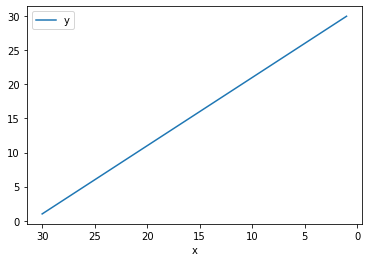

In [108]:
import matplotlib.pyplot as plt 
pd.DataFrame({'x':np.arange(30,0,-1),'y':np.arange(1,31)}).plot(x='x',y='y')
plt.gca().invert_xaxis()

In [120]:
xs = np.arange(30,0,-1)
ys = np.arange(1,31)
ff = go.Figure(data=[go.Scatter(x=xs,y=ys)])
ff.update_layout(xaxis={'type':'category'})
ff.update_layout(xaxis={'type':'-','autorange':'reversed'})

## END